In [ ]:
# Bibliotecas (geral)
!pip install -q gdown
!pip install -q cartopy

import math
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 64.6 MB/s eta 0:00:00


In [ ]:
# Baixar dados de entrada
gdown.download(f'https://drive.google.com/uc?id=1yMd_GkSw8o2__WYPpB-dWA6Uip2HjYjR', 'backtrajectories.csv', quiet=True)
gdown.download(f'https://drive.google.com/uc?id=1h-BZD6eUxyuli_2Du28o6g6eaMRE7msc', 'dates.csv', quiet=True)

# Carregar dados
data = pd.read_csv('backtrajectories.csv', header=None, delimiter=',').to_numpy()
dates = pd.read_csv('dates.csv', header=None, delimiter=',').to_numpy()

In [ ]:
# Agrupamento usando o método hierárquico de Ward

# Bibliotecas (cluster)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

X = data

# Padronização por blocos (latitude, longitude e altitude)
n_blocks = 3
block_size = 121
n_rows, n_cols = X.shape

X_std = np.empty_like(X, dtype=float)

for i in range(n_blocks):
    start = i * block_size
    end = start + block_size
    block = X[start:end, :]

    mean = block.mean(axis=0, keepdims=True)
    std = block.std(axis=0, ddof=0, keepdims=True)

    std[std == 0] = 1

    X_std[start:end, :] = (block - mean) / std # Média = 0 e Desvio padrão = 1

X_std = X_std.T

G = 8 # Número de grupos
D = pdist(X_std, metric='euclidean') # Tipo de distância
L = linkage(D, method='ward') # Método
C = fcluster(L, t=G, criterion='maxclust')

cut_height = L[-G + 1, 2]

df_clusters = pd.DataFrame({'date': pd.to_datetime(dict(year=dates[:,0] + 2000, month=dates[:,1], day=dates[:,2])), 'cluster': C})

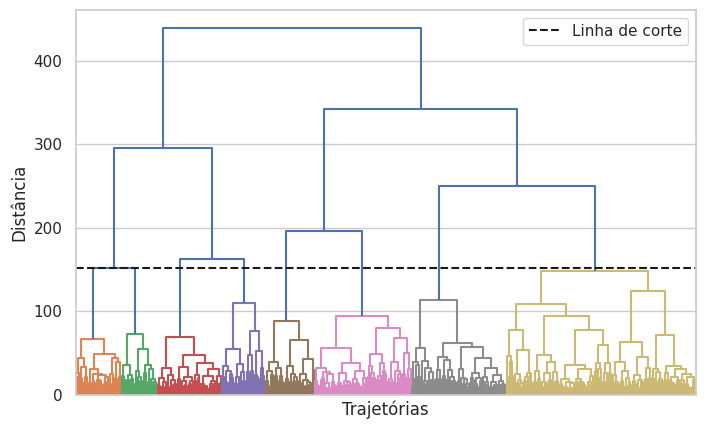

In [ ]:
# Dendograma
plt.figure(figsize=(8, 5))
dendrogram(L, color_threshold=cut_height, no_labels=True, p=30, show_leaf_counts=True)
plt.axhline(y=cut_height, color='k', linestyle='--', label=f'Linha de corte')
plt.xlabel('Trajetórias')
plt.ylabel('Distância')
plt.legend()
plt.savefig('ward_dendrogram.png', dpi=600, bbox_inches='tight')
plt.show()

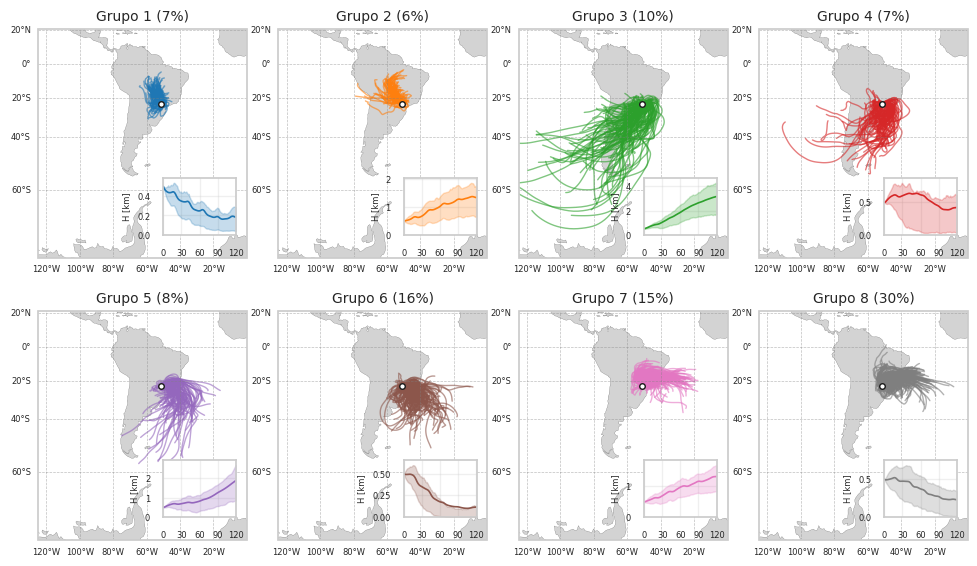

In [ ]:
# Resultados - Mapa de trajetórias por grupo
n_coord = 121
lon_ref = -51.1137
lat_ref = -23.3074

colors = plt.cm.tab10(np.arange(G))

fig, axes = plt.subplots(2, 4, figsize=(12, 7),
                         subplot_kw={'projection': ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes[:G]):

    idx = np.where(C == i + 1)[0]
    lats = X[:n_coord, idx]
    lons = X[n_coord:2*n_coord, idx]
    hs   = X[2*n_coord:, idx] / 1000

    ax.set_extent([-125, 0, -60, 10])
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, lw=0.1)
    ax.plot(lons, lats, c=colors[i], transform=ccrs.PlateCarree(), lw=1, alpha=0.6)
    ax.plot(lon_ref, lat_ref, 'wo', markeredgecolor='k', markersize=4, transform=ccrs.PlateCarree())
    ax.set_title(f'Grupo {i+1} ({len(idx)/len(C):.0%})', fontsize=10)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}

    ins = ax.inset_axes([0.6, 0.1, 0.35, 0.25])
    mean_h = np.nanmean(hs, axis=1)
    p_min, p_max = np.nanpercentile(hs, [25, 75], axis=1)

    ins.plot(mean_h, c=colors[i], lw=1.2)
    ins.fill_between(range(n_coord), p_min, p_max, color=colors[i], alpha=0.25)

    ins.set(xlim=(0, n_coord), ylim=(0, np.nanmax(p_max) * 1.1), xticks=np.arange(0, 121, 30))
    ins.set_ylabel('H [km]', fontsize=6)
    ins.tick_params(labelsize=6); ins.grid(True, alpha=0.3)

[fig.delaxes(ax) for ax in axes[G:]]

plt.subplots_adjust(wspace=0.15, hspace=0.1)
plt.savefig('ward_backtrajectories.png', dpi=600, bbox_inches='tight')
plt.show()

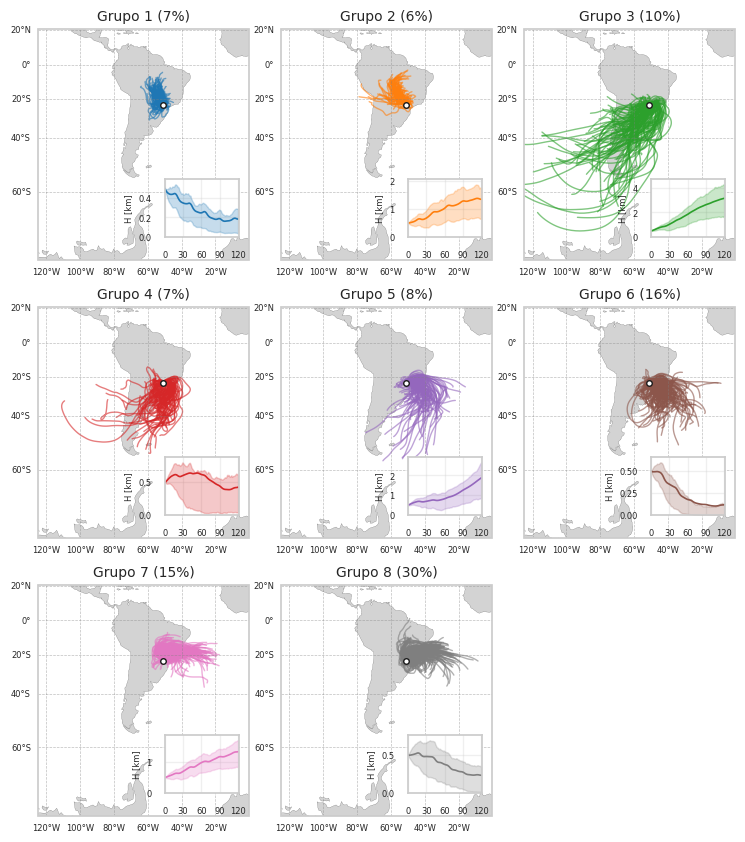

In [ ]:
# Resultados - Mapa de trajetórias por grupo
n_coord = 121
lon_ref = -51.1137
lat_ref = -23.3074

colors = plt.cm.tab10(np.arange(G))

fig, axes = plt.subplots(3, 3, figsize=(9, 10.5),
                         subplot_kw={'projection': ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes[:G]):

    idx = np.where(C == i + 1)[0]
    lats = X[:n_coord, idx]
    lons = X[n_coord:2*n_coord, idx]
    hs   = X[2*n_coord:, idx] / 1000

    ax.set_extent([-125, 0, -60, 10])
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, lw=0.1)
    ax.plot(lons, lats, c=colors[i], transform=ccrs.PlateCarree(), lw=1, alpha=0.6)
    ax.plot(lon_ref, lat_ref, 'wo', markeredgecolor='k', markersize=4, transform=ccrs.PlateCarree())
    ax.set_title(f'Grupo {i+1} ({len(idx)/len(C):.0%})', fontsize=10)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}

    ins = ax.inset_axes([0.6, 0.1, 0.35, 0.25])
    mean_h = np.nanmean(hs, axis=1)
    p_min, p_max = np.nanpercentile(hs, [25, 75], axis=1)

    ins.plot(mean_h, c=colors[i], lw=1.2)
    ins.fill_between(range(n_coord), p_min, p_max, color=colors[i], alpha=0.25)

    ins.set(xlim=(0, n_coord), ylim=(0, np.nanmax(p_max) * 1.1), xticks=np.arange(0, 121, 30))
    ins.set_ylabel('H [km]', fontsize=6)
    ins.tick_params(labelsize=6); ins.grid(True, alpha=0.3)

[fig.delaxes(ax) for ax in axes[G:]]

plt.subplots_adjust(wspace=0.15, hspace=0.1)
plt.savefig('ward_backtrajectories.png', dpi=600, bbox_inches='tight')
plt.show()

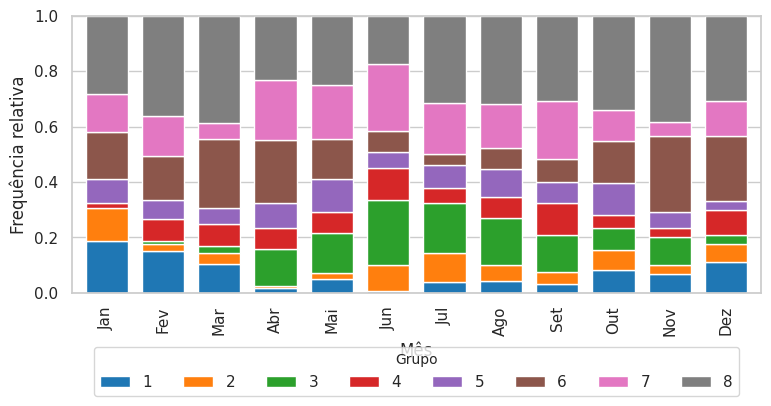

In [ ]:
# Resultados - Frequência por grupo e mês do ano
df_clusters['month'] = df_clusters['date'].dt.month

pivot = df_clusters.groupby(['month', 'cluster']).size().unstack(fill_value=0)
pivot = pivot.div(pivot.sum(axis=1), axis=0)

month_label = {1:'Jan',2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez'}

pivot = (df_clusters.assign(month=df_clusters['date'].dt.month.map(month_label))
         .groupby(['month','cluster'])
         .size()
         .unstack(fill_value=0)
         .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
         .reindex(month_label.values()))

fig, ax = plt.subplots(figsize=(8, 4.5))
colors = plt.cm.tab10(np.arange(G))

pivot.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.75)

ax.set_ylim(0, 1)
ax.set_xlabel('Mês')
ax.set_ylabel('Frequência relativa')
ax.legend(title='Grupo', loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=8, frameon=True, title_fontsize=10)

plt.savefig('ward_barplot.png', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# Carregar dados de BC
from google.colab import drive
from scipy.io import loadmat

drive.mount('/content/drive/', force_remount=True)

bc = np.array(loadmat('/content/drive/My Drive/IANS/bc_hourly_mean_2014-2017.mat')['bc_hourly'])

df_bc = (pd.DataFrame({'date': pd.to_datetime({'year': bc[:,1], 'month': bc[:,2], 'day': bc[:,3]}), 'bc': bc[:,14]})
            .merge(df_clusters, on='date')
            .assign(row_id=lambda x: x.groupby('cluster').cumcount())
            .pivot(index='row_id', columns='cluster', values='bc')
            .rename(columns=lambda x: str(int(x)))
            .div(1e3))

Mounted at /content/drive/


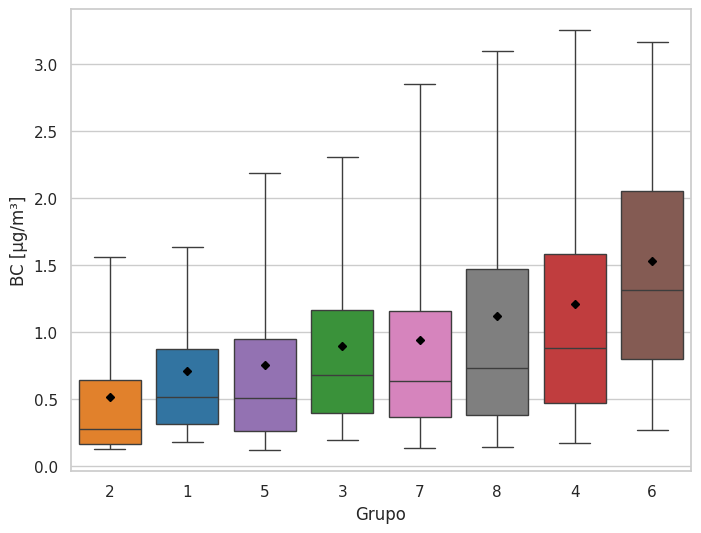

In [ ]:
# Boxplot organizado pelas médias (menor para maior)
sorted_clusters = df_bc.mean().sort_values().index.tolist()

sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_bc, order=sorted_clusters, whis=(5, 95), showfliers=False, palette='tab10', showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': '4'})

plt.xlabel('Grupo')
plt.ylabel('BC [μg/m³]')
plt.savefig('ward_bc_conc.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Agrupamento usando o método de densidade e conectividade HDBSCAN

# Bibliotecas (cluster)
from sklearn.cluster import HDBSCAN

X = data

# Padronização por blocos (latitude, longitude e altitude)
n_blocks = 3
block_size = 121
n_rows, n_cols = X.shape

X_std = np.empty_like(X, dtype=float)

for i in range(n_blocks):
    start = i * block_size
    end = start + block_size
    block = X[start:end, :]

    mean = block.mean(axis=0, keepdims=True)
    std = block.std(axis=0, ddof=0, keepdims=True)

    std[std == 0] = 1

    X_std[start:end, :] = (block - mean) / std # Média = 0 e Desvio padrão = 1

X_std = X_std.T

# Hiperparâmetros escolhidos abritariamente
clusterer = HDBSCAN(min_cluster_size=8, leaf_size=80, cluster_selection_method='leaf', metric='euclidean')

clusterer.fit(X_std)
C = clusterer.labels_

C_unique = sorted([x for x in np.unique(C) if x != -1])
G = len(C_unique)

C_mapped = np.full_like(C, -1)
for i, label in enumerate(C_unique):
    C_mapped[C == label] = i + 1
C = C_mapped

print(f'Número de grupos: {G}')
print(f'Ruído: {(np.sum(C == -1))}')
print(f'Ruído (porcentagem): {(np.sum(C == -1) / len(C)) * 100:.2f}%')

df_clusters = pd.DataFrame({'date': pd.to_datetime(dict(year=dates[:,0] + 2000, month=dates[:,1], day=dates[:,2])), 'cluster': C})

Número de grupos: 8
Ruído: 971
Ruído (porcentagem): 66.69%


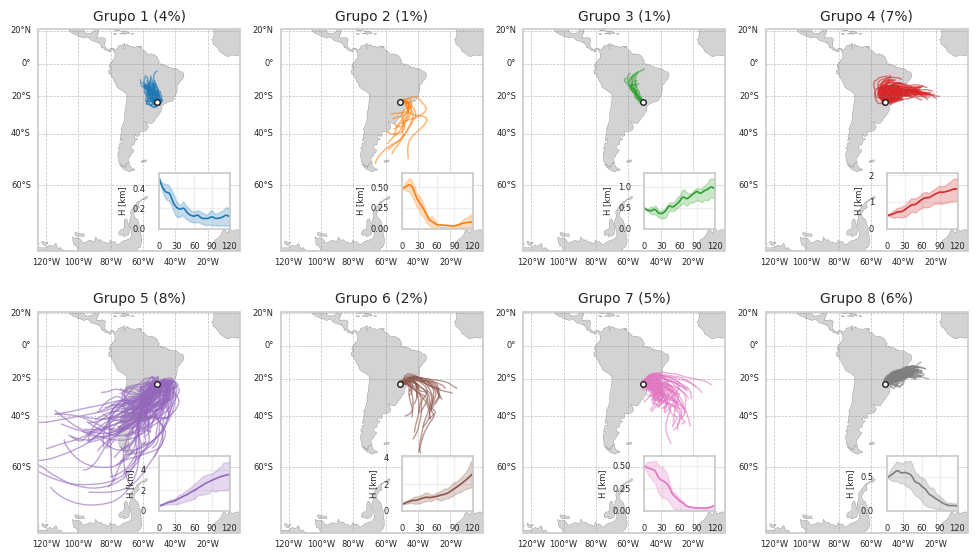

In [ ]:
# Resultados - Mapa de trajetórias por grupo
n_coord = 121
lon_ref = -51.1137
lat_ref = -23.3074

colors = plt.cm.tab10(np.arange(G))

fig, axes = plt.subplots(2, 4, figsize=(12, 7),
                         subplot_kw={'projection': ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes[:G]):

    idx = np.where(C == i + 1)[0]
    lats = X[:n_coord, idx]
    lons = X[n_coord:2*n_coord, idx]
    hs   = X[2*n_coord:, idx] / 1000

    ax.set_extent([-125, 0, -60, 10])
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, lw=0.1)
    ax.plot(lons, lats, c=colors[i], transform=ccrs.PlateCarree(), lw=1, alpha=0.6)
    ax.plot(lon_ref, lat_ref, 'wo', markeredgecolor='k', markersize=4, transform=ccrs.PlateCarree())
    ax.set_title(f'Grupo {i+1} ({len(idx)/len(C):.0%})', fontsize=10)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}

    ins = ax.inset_axes([0.6, 0.1, 0.35, 0.25])
    mean_h = np.nanmean(hs, axis=1)
    p_min, p_max = np.nanpercentile(hs, [25, 75], axis=1)

    ins.plot(mean_h, c=colors[i], lw=1.2)
    ins.fill_between(range(n_coord), p_min, p_max, color=colors[i], alpha=0.25)

    ins.set(xlim=(0, n_coord), ylim=(0, np.nanmax(p_max) * 1.1), xticks=np.arange(0, 121, 30))
    ins.set_ylabel('H [km]', fontsize=6)
    ins.tick_params(labelsize=6); ins.grid(True, alpha=0.3)

[fig.delaxes(ax) for ax in axes[G:]]

plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig('hdbscan_backtrajectories.png', dpi=600, bbox_inches='tight')
plt.show()

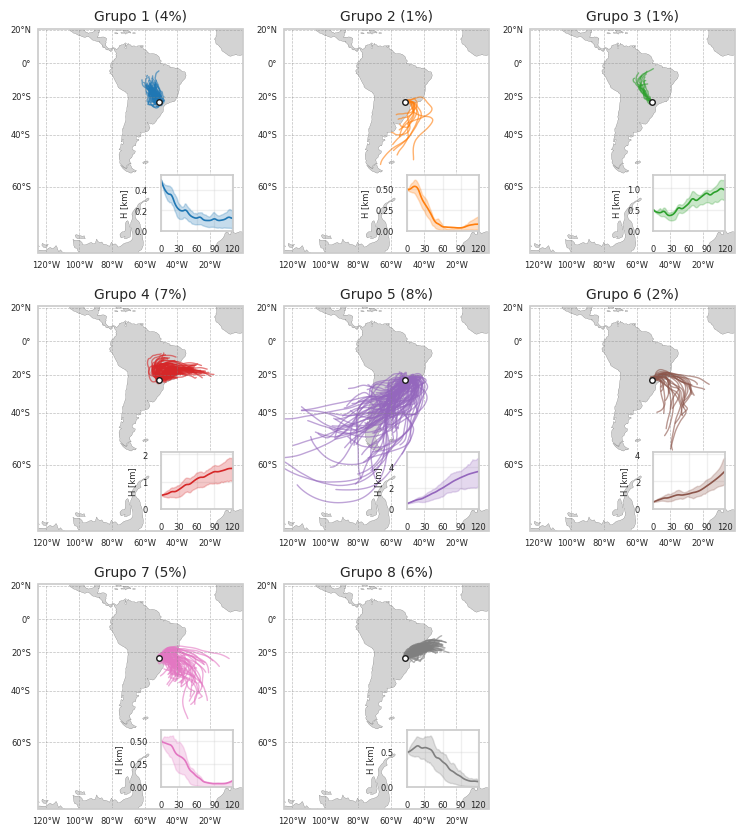

In [ ]:
# Resultados - Mapa de trajetórias por grupo
n_coord = 121
lon_ref = -51.1137
lat_ref = -23.3074

colors = plt.cm.tab10(np.arange(G))

fig, axes = plt.subplots(3, 3, figsize=(9, 10.5),
                         subplot_kw={'projection': ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes[:G]):

    idx = np.where(C == i + 1)[0]
    lats = X[:n_coord, idx]
    lons = X[n_coord:2*n_coord, idx]
    hs   = X[2*n_coord:, idx] / 1000

    ax.set_extent([-125, 0, -60, 10])
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, lw=0.1)
    ax.plot(lons, lats, c=colors[i], transform=ccrs.PlateCarree(), lw=1, alpha=0.6)
    ax.plot(lon_ref, lat_ref, 'wo', markeredgecolor='k', markersize=4, transform=ccrs.PlateCarree())
    ax.set_title(f'Grupo {i+1} ({len(idx)/len(C):.0%})', fontsize=10)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}

    ins = ax.inset_axes([0.6, 0.1, 0.35, 0.25])
    mean_h = np.nanmean(hs, axis=1)
    p_min, p_max = np.nanpercentile(hs, [25, 75], axis=1)

    ins.plot(mean_h, c=colors[i], lw=1.2)
    ins.fill_between(range(n_coord), p_min, p_max, color=colors[i], alpha=0.25)

    ins.set(xlim=(0, n_coord), ylim=(0, np.nanmax(p_max) * 1.1), xticks=np.arange(0, 121, 30))
    ins.set_ylabel('H [km]', fontsize=6)
    ins.tick_params(labelsize=6); ins.grid(True, alpha=0.3)

[fig.delaxes(ax) for ax in axes[G:]]

plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig('hdbscan_backtrajectories.png', dpi=600, bbox_inches='tight')
plt.show()

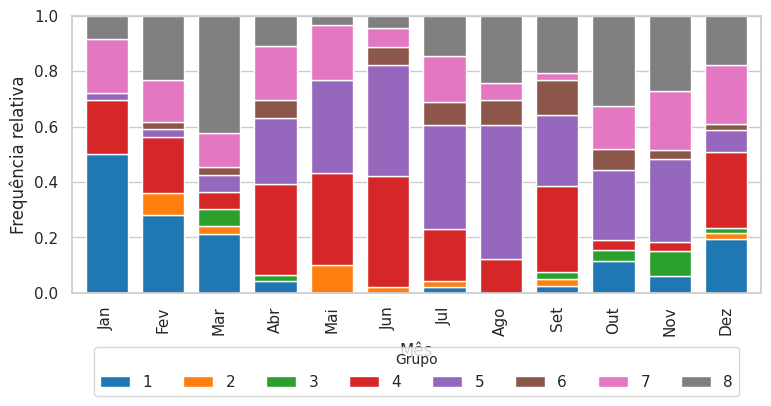

In [ ]:
# Resultados - Frequência por grupo e mês do ano
df_clusters['month'] = df_clusters['date'].dt.month
df_clusters = df_clusters[df_clusters['cluster'] != -1]

pivot = df_clusters.groupby(['month', 'cluster']).size().unstack(fill_value=0)
pivot = pivot.div(pivot.sum(axis=1), axis=0)

month_label = {1:'Jan',2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez'}

pivot = (df_clusters.assign(month=df_clusters['date'].dt.month.map(month_label))
         .groupby(['month','cluster'])
         .size()
         .unstack(fill_value=0)
         .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
         .reindex(month_label.values()))

fig, ax = plt.subplots(figsize=(8, 4.5))
colors = plt.cm.tab10(np.arange(G))

pivot.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.75)

ax.set_ylim(0, 1)
ax.set_xlabel('Mês')
ax.set_ylabel('Frequência relativa')
ax.legend(title='Grupo', loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=8, frameon=True, title_fontsize=10)

plt.savefig('hdbscan_barplot.png', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# Carregar dados de BC
from google.colab import drive
from scipy.io import loadmat

drive.mount('/content/drive/', force_remount=True)

bc = np.array(loadmat('/content/drive/My Drive/IANS/bc_hourly_mean_2014-2017.mat')['bc_hourly'])

df_bc = (pd.DataFrame({'date': pd.to_datetime({'year': bc[:,1], 'month': bc[:,2], 'day': bc[:,3]}), 'bc': bc[:,14]})
            .merge(df_clusters, on='date')
            .query('cluster != -1')
            .assign(row_id=lambda x: x.groupby('cluster').cumcount())
            .pivot(index='row_id', columns='cluster', values='bc')
            .rename(columns=lambda x: str(int(x)))
            .div(1e3))

Mounted at /content/drive/


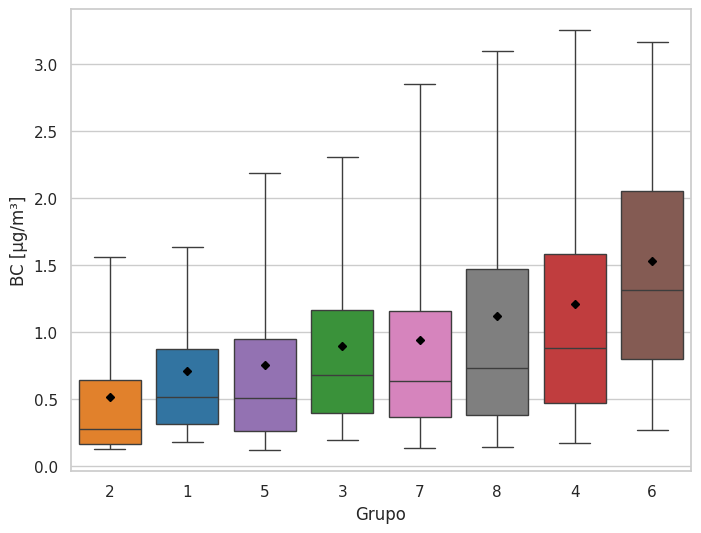

In [ ]:
# Boxplot organizado pelas médias (menor para maior)
sorted_clusters = df_bc.mean().sort_values().index.tolist()

sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_bc, order=sorted_clusters, whis=(5, 95), showfliers=False, palette='tab10', showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': '4'})

plt.xlabel('Grupo')
plt.ylabel('BC [μg/m³]')
plt.savefig('hdbscan_bc_conc.png', dpi=600, bbox_inches='tight')
plt.show()